In [1]:
# Core libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Time series decomposition & diagnostics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

# ARIMA modeling
from statsmodels.tsa.arima.model import ARIMA

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Utility
from itertools import combinations, product
import scipy.stats as stats

In [2]:
df = pd.read_csv('PALUMUSDM.csv')
df.head()

,observation_date,PALUMUSDM
0,1990-01-01,1528.0
1,1990-02-01,1454.0
2,1990-03-01,1567.0
3,1990-04-01,1526.0
4,1990-05-01,1527.0


In [3]:
df = df.set_index('observation_date')
df.head()

,PALUMUSDM
observation_date,
1990-01-01,1528.0
1990-02-01,1454.0
1990-03-01,1567.0
1990-04-01,1526.0
1990-05-01,1527.0


In [4]:
df.index = pd.to_datetime(df.index)
df = df[df.index >= '2010-01-01']

print(f"Filtered data starts from: {df.index.min().date()}")
print(f"Ends at: {df.index.max().date()}")

df.head()

Filtered data starts from: 2010-01-01
Ends at: 2025-04-01


,PALUMUSDM
observation_date,
2010-01-01,2230.112500
2010-02-01,2053.270000
2010-03-01,2210.530435
2010-04-01,2314.277500
2010-05-01,2044.710526


                    PALUMUSDM
observation_date             
2010-01-01        2230.112500
2010-02-01        2053.270000
2010-03-01        2210.530435
2010-04-01        2314.277500
2010-05-01        2044.710526


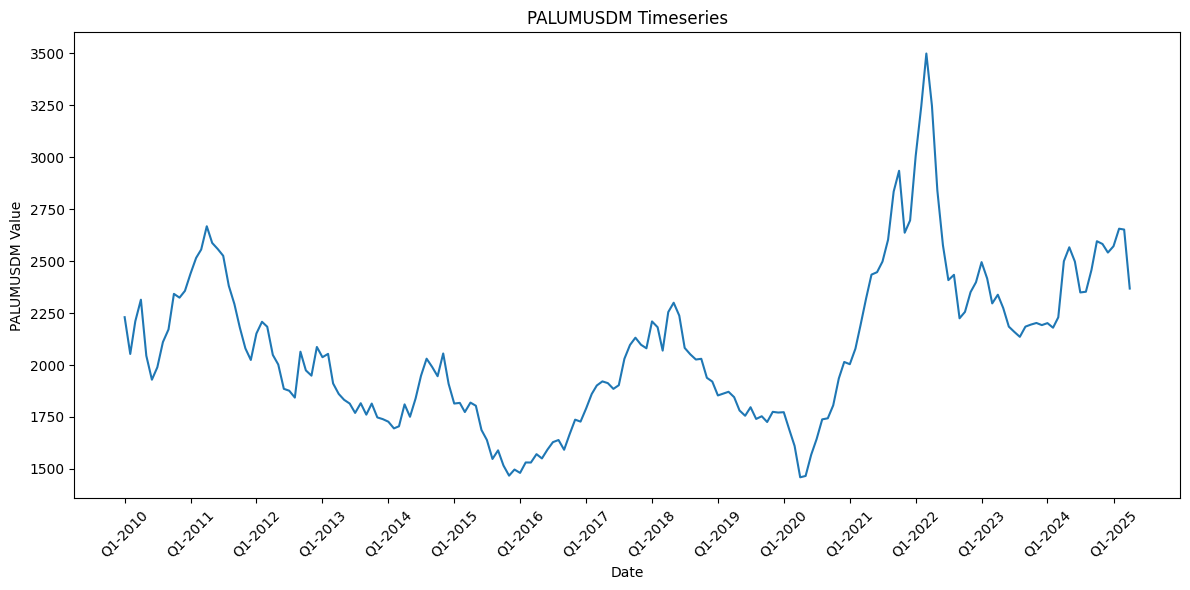

In [5]:
df.index = pd.to_datetime(df.index)

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['PALUMUSDM'], label='PALUMUSDM')

plt.xlabel('Date')
plt.ylabel('PALUMUSDM Value')
plt.title('PALUMUSDM Timeseries')

locator = mdates.MonthLocator(bymonth=[1, 4, 7, 10])
plt.gca().xaxis.set_major_locator(locator)

tick_positions = df.index[df.index.month.isin([1, 4, 7, 10])].drop_duplicates()
tick_labels = [f"Q{((d.month - 1)//3) + 1}-{d.year}" for d in tick_positions]

plt.xticks(ticks=tick_positions[::4], 
           labels=tick_labels[::4],
           rotation=45)

print(df.head())

plt.tight_layout()
plt.show()

In [6]:
df.head()

,PALUMUSDM
observation_date,
2010-01-01,2230.112500
2010-02-01,2053.270000
2010-03-01,2210.530435
2010-04-01,2314.277500
2010-05-01,2044.710526


In [7]:
df.index = pd.to_datetime(df.index)
series = df['PALUMUSDM'].dropna().sort_index()

val_size = 5

val_start = -val_size

train = series[:val_start]
val = series[val_start:]

print(f"Train size: {len(train)}")
print(f"Validation size: {len(val)}")

print(f"\nTrain: {train.index[0].date()} to {train.index[-1].date()}")
print(f"Validation: {val.index[0].date()} to {val.index[-1].date()}")

Train size: 179
Validation size: 5

Train: 2010-01-01 to 2024-11-01
Validation: 2024-12-01 to 2025-04-01


In [8]:
train = pd.DataFrame(train)
val = pd.DataFrame(val)

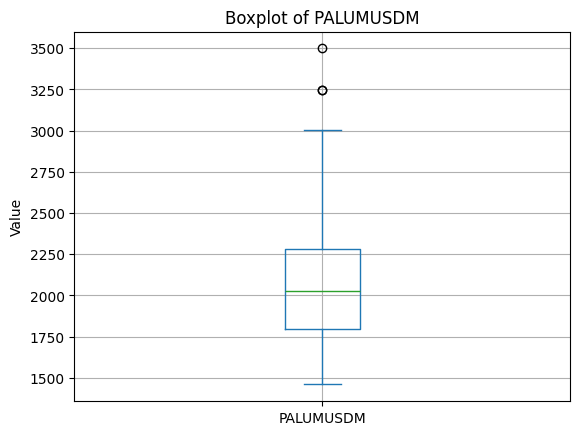

In [9]:
train['PALUMUSDM'].plot.box()
plt.title('Boxplot of PALUMUSDM')
plt.ylabel('Value')
plt.grid(True)
plt.show()

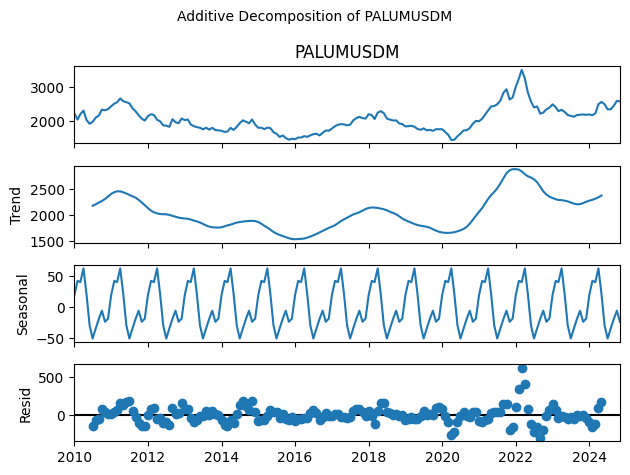

In [10]:
result = seasonal_decompose(train['PALUMUSDM'], model='additive', period=12)  # 12 for monthly seasonality

result.plot()
plt.suptitle('Additive Decomposition of PALUMUSDM', fontsize=10)
plt.tight_layout()
plt.show()

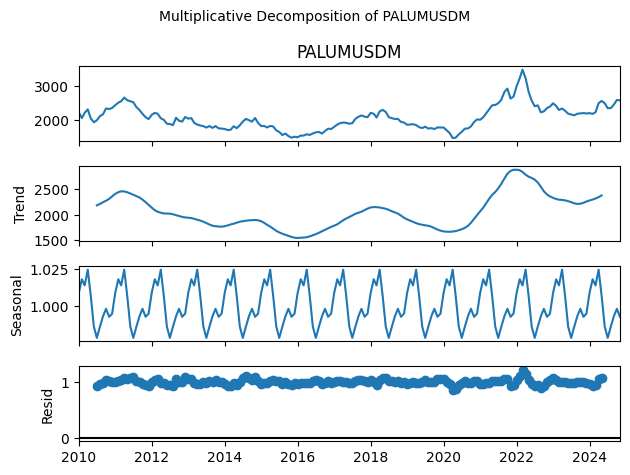

In [11]:
result = seasonal_decompose(train['PALUMUSDM'], model='multiplicative', period=12)

result.plot()
plt.suptitle('Multiplicative Decomposition of PALUMUSDM', fontsize=10)
plt.tight_layout()
plt.show()

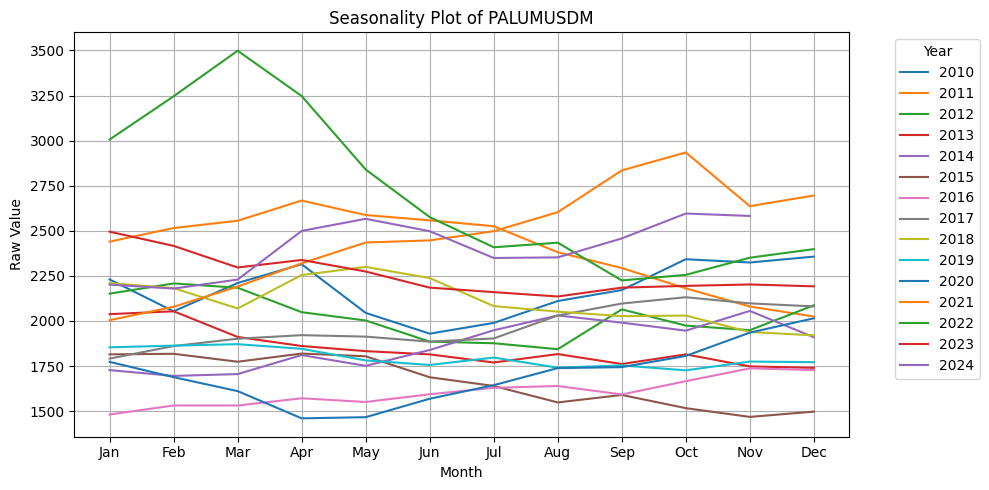

In [12]:
data = train[['PALUMUSDM']].copy()

data['month'] = data.index.month
data['year'] = data.index.year

pivot = data.pivot(index='month', columns='year', values='PALUMUSDM')

plt.figure(figsize=(10, 5))
for year in pivot.columns:
    plt.plot(pivot.index, pivot[year], label=str(year))

plt.title('Seasonality Plot of PALUMUSDM')
plt.xlabel('Month')
plt.ylabel('Raw Value')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


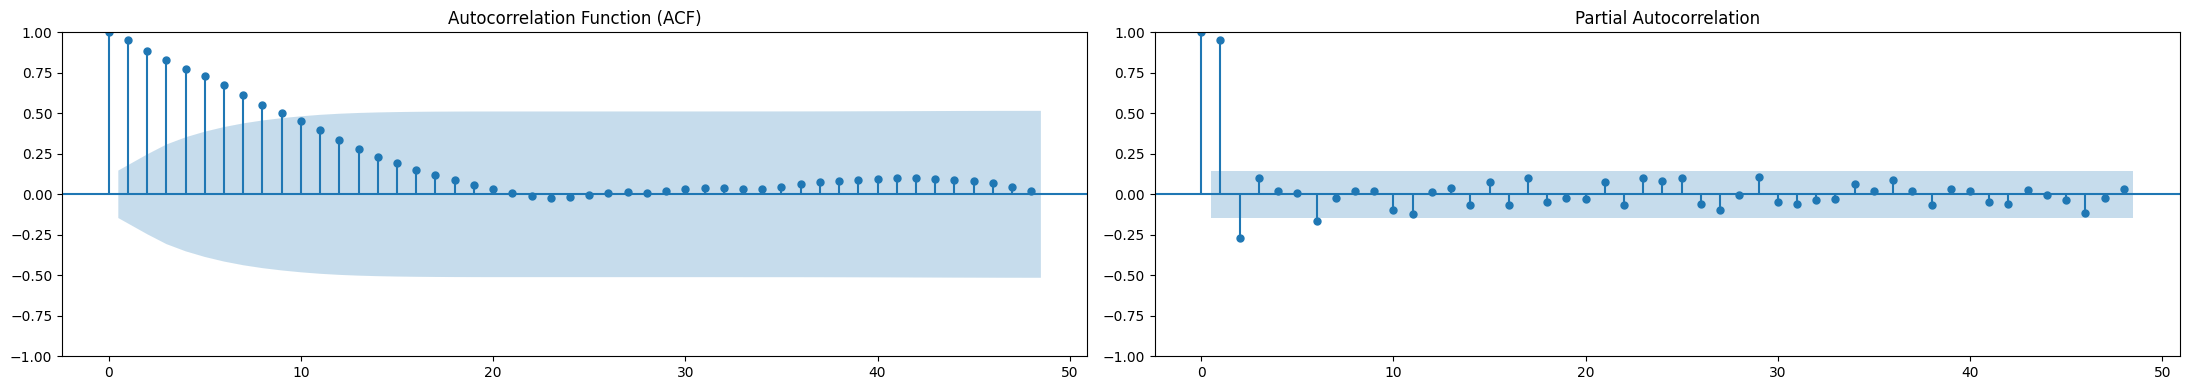

In [13]:
series = train['PALUMUSDM'].dropna()

plt.figure(figsize=(22, 4))

plt.subplot(1, 2, 1)
plot_acf(series, lags=48, ax=plt.gca())
plt.title("Autocorrelation Function (ACF)")

plt.subplot(1, 2, 2)
plot_pacf(series, lags=48, ax=plt.gca(), method='ywmle')

plt.tight_layout()
plt.show()

In [14]:
series = train['PALUMUSDM'].dropna()

result = adfuller(series)

print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

if result[1] <= 0.05:
    print(" Reject the null hypothesis — the series IS stationary.")
else:
    print(" Fail to reject the null hypothesis — the series is NOT stationary.")

ADF Statistic: -2.3514330677079576
p-value: 0.15591563272231956
Critical Values:
   1%: -3.467845319799907
   5%: -2.878011745497439
   10%: -2.575551186759871
 Fail to reject the null hypothesis — the series is NOT stationary.


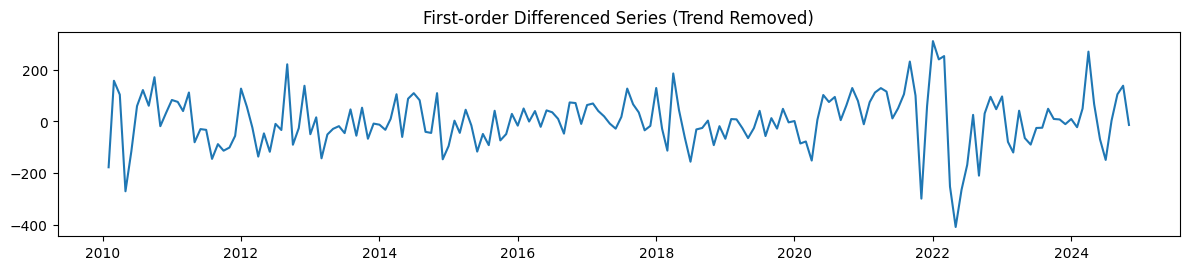

In [15]:
train['trend_diff'] = train['PALUMUSDM'].diff()

plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
plt.plot(train['trend_diff'])
plt.title("First-order Differenced Series (Trend Removed)")

plt.tight_layout()
plt.show()

In [16]:
series = train['trend_diff'].dropna()

result = adfuller(series)

print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

if result[1] <= 0.05:
    print("Reject the null hypothesis — the series IS stationary.")
else:
    print("Fail to reject the null hypothesis — the series is NOT stationary.")

ADF Statistic: -9.15917446032433
p-value: 2.5606240009529245e-15
Critical Values:
   1%: -3.4680615871598537
   5%: -2.8781061899535128
   10%: -2.5756015922004134
Reject the null hypothesis — the series IS stationary.


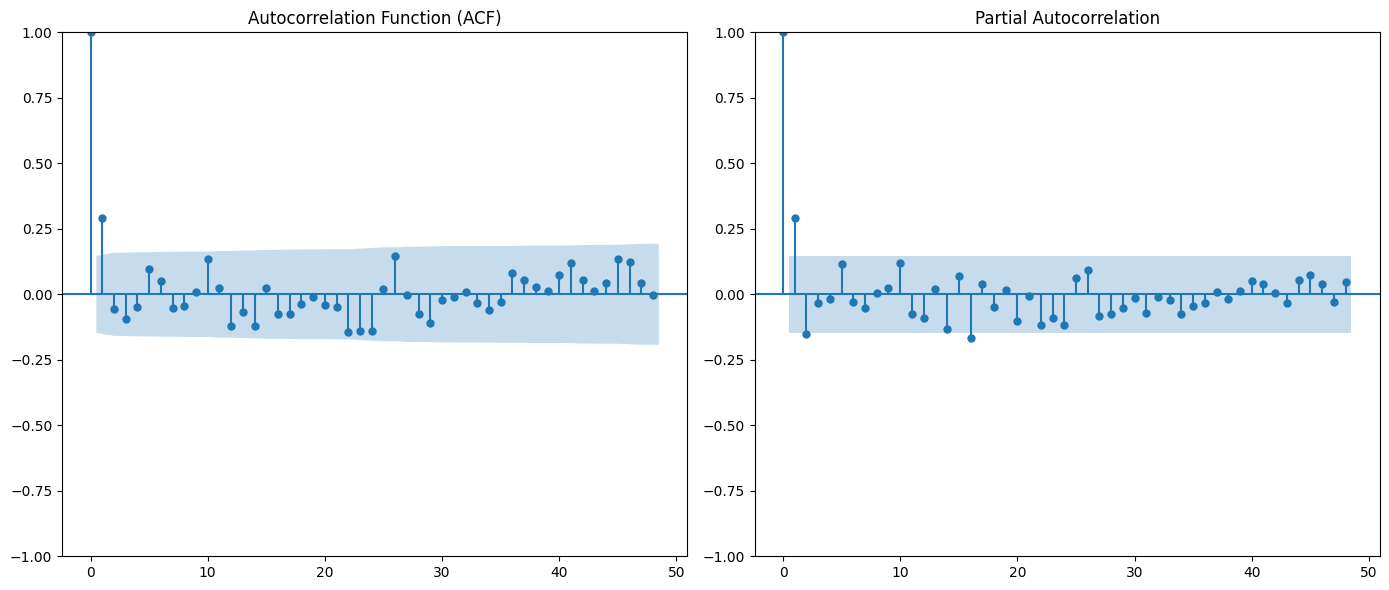

In [17]:
series = train['trend_diff'].dropna()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_acf(series, lags=48, ax=plt.gca())
plt.title("Autocorrelation Function (ACF)")

plt.subplot(1, 2, 2)
plot_pacf(series, lags=48, ax=plt.gca(), method='ywmle') 

plt.tight_layout()
plt.show()

In [18]:
train.index = pd.to_datetime(train.index)

train['dummy_covid_dip'] = ((train.index >= '2020-03-01') & (train.index <= '2020-06-01')).astype(int)
train['dummy_covid_surge'] = ((train.index >= '2020-08-01') & (train.index <= '2021-12-01')).astype(int)
train['dummy_ukraine_war'] = ((train.index >= '2022-01-01') & (train.index <= '2022-04-01')).astype(int)

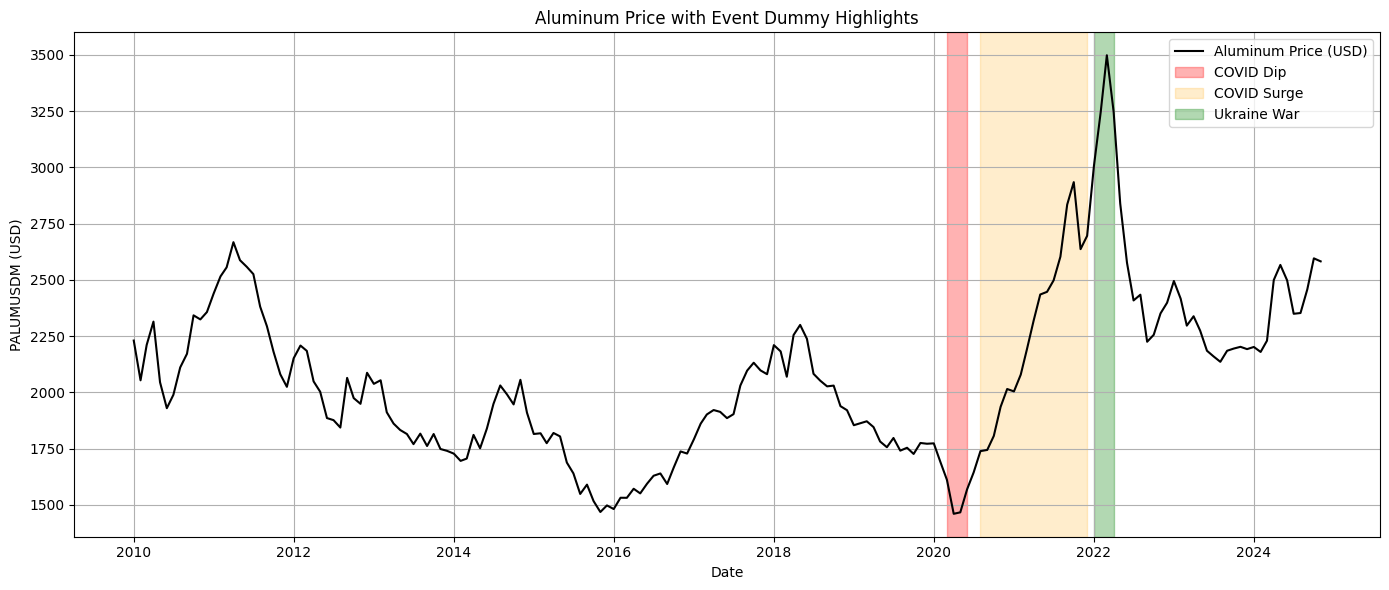

In [19]:
train.index = pd.to_datetime(train.index)

plt.figure(figsize=(14, 6))
plt.plot(train['PALUMUSDM'], label='Aluminum Price (USD)', color='black')

plt.axvspan(pd.to_datetime('2020-03-01'), pd.to_datetime('2020-06-01'), color='red', alpha=0.3, label='COVID Dip')
plt.axvspan(pd.to_datetime('2020-08-01'), pd.to_datetime('2021-12-01'), color='orange', alpha=0.2, label='COVID Surge')
plt.axvspan(pd.to_datetime('2022-01-01'), pd.to_datetime('2022-04-01'), color='green', alpha=0.3, label='Ukraine War')

plt.title("Aluminum Price with Event Dummy Highlights")
plt.xlabel("Date")
plt.ylabel("PALUMUSDM (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
for col in ['dummy_covid_dip', 'dummy_covid_surge', 'dummy_ukraine_war']:
    if col not in val.columns:
        val[col] = 0  

y_train = train['PALUMUSDM'].dropna()
exog_train = train[['dummy_covid_dip', 'dummy_covid_surge', 'dummy_ukraine_war']].loc[y_train.index]

y_val = val['PALUMUSDM']
exog_val = val[['dummy_covid_dip', 'dummy_covid_surge', 'dummy_ukraine_war']].loc[y_val.index]

p_range = range(0, 4)
d_range = range(0, 2)
q_range = range(0, 4)

results = []

for p, d, q in product(p_range, d_range, q_range):
    try:
        model = ARIMA(y_train, order=(p, d, q), exog=exog_train)
        fitted = model.fit()

        forecast_result = fitted.get_forecast(steps=len(y_val), exog=exog_val)
        y_pred = forecast_result.predicted_mean
        y_pred.index = y_val.index  

        mask = y_val != 0
        mae = mean_absolute_error(y_val, y_pred)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mape = np.mean(np.abs((y_val[mask] - y_pred[mask]) / y_val[mask])) * 100

        results.append({
            'Order': (p, d, q),
            'AIC': round(fitted.aic, 2),
            'MAE': round(mae, 2),
            'RMSE': round(rmse, 2),
            'MAPE (%)': round(mape, 2),
            'Model': fitted
        })

    except Exception as e:
        print(f" Failed for ARIMA({p},{d},{q}): {e}")
        continue

results_df = pd.DataFrame(results)

if not results_df.empty:
    results_df = results_df.sort_values(by='AIC')
    best_row = results_df.iloc[0]

    print("\n Best ARIMA Order (by AIC):", best_row['Order'])
    print(" AIC:", best_row['AIC'])
    print("\n Best Model Summary:\n")
    print(best_row['Model'].summary())

    print("\n All Models (Evaluated on Validation Set):\n")
    print(results_df[['Order', 'AIC', 'MAE', 'RMSE', 'MAPE (%)']].to_string(index=False))
else:
    print(" No valid ARIMA models were successfully fit.")

/Users/moneesh/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/moneesh/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/moneesh/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/moneesh/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/moneesh/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency informa


 Best ARIMA Order (by AIC): (1, 1, 1)
 AIC: 2127.8

 Best Model Summary:

                               SARIMAX Results                                
Dep. Variable:              PALUMUSDM   No. Observations:                  179
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1057.899
Date:                Sun, 18 May 2025   AIC                           2127.798
Time:                        23:50:58   BIC                           2146.889
Sample:                    01-01-2010   HQIC                          2135.540
                         - 11-01-2024                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
dummy_covid_dip     -71.1820    351.699     -0.202      0.840    -760.500     618.136
dummy_covid_surge   100.9455    129

/Users/moneesh/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/moneesh/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/moneesh/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/moneesh/miniforge3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [21]:
results_df

,Order,AIC,MAE,RMSE,MAPE (%),Model
13,"(1, 1, 1)",2127.80,78.35,103.67,3.14,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
5,"(0, 1, 1)",2128.82,80.27,106.15,3.22,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
14,"(1, 1, 2)",2128.93,78.28,103.70,3.14,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
21,"(2, 1, 1)",2128.95,78.47,103.74,3.14,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
12,"(1, 1, 0)",2129.72,81.46,107.15,3.28,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
23,"(2, 1, 3)",2129.97,81.41,105.62,3.28,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
6,"(0, 1, 2)",2130.23,79.81,105.31,3.20,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
20,"(2, 1, 0)",2130.65,81.04,105.34,3.25,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
29,"(3, 1, 1)",2130.89,77.82,103.56,3.12,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
15,"(1, 1, 3)",2130.92,78.26,103.69,3.14,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


In [22]:
y = train['PALUMUSDM'].dropna()
exog = train[['dummy_covid_dip', 'dummy_covid_surge', 'dummy_ukraine_war']].loc[y.index]

model = ARIMA(y, order=(1, 1, 1), exog=exog)
result_with_dummy = model.fit()

print(result_with_dummy.summary())

/Users/moneesh/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/moneesh/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/moneesh/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              PALUMUSDM   No. Observations:                  179
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1057.899
Date:                Sun, 18 May 2025   AIC                           2127.798
Time:                        23:50:58   BIC                           2146.889
Sample:                    01-01-2010   HQIC                          2135.540
                         - 11-01-2024                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
dummy_covid_dip     -71.1820    351.699     -0.202      0.840    -760.500     618.136
dummy_covid_surge   100.9455    129.247      0.781      0.435    -152.375     354.266
dummy_ukraine_war   398.

In [23]:
y = train['PALUMUSDM'].dropna()
exog = train[['dummy_covid_surge', 'dummy_ukraine_war']].loc[y.index]

model = ARIMA(y, order=(1, 1, 1), exog=exog)
result_with_dummy = model.fit()

print(result_with_dummy.summary())

                               SARIMAX Results                                
Dep. Variable:              PALUMUSDM   No. Observations:                  179
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1058.407
Date:                Sun, 18 May 2025   AIC                           2126.814
Time:                        23:50:59   BIC                           2142.723
Sample:                    01-01-2010   HQIC                          2133.266
                         - 11-01-2024                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
dummy_covid_surge    98.5594    119.892      0.822      0.411    -136.425     333.544
dummy_ukraine_war   396.6805    243.133      1.632      0.103     -79.851     873.212
ar.L1                -0.

/Users/moneesh/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/moneesh/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/moneesh/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [24]:
y = train['PALUMUSDM'].dropna()
exog = train[['dummy_ukraine_war']].loc[y.index]

model = ARIMA(y, order=(1, 1, 1), exog=exog)
result_with_dummy = model.fit()

print(result_with_dummy.summary())

                               SARIMAX Results                                
Dep. Variable:              PALUMUSDM   No. Observations:                  179
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1059.310
Date:                Sun, 18 May 2025   AIC                           2126.620
Time:                        23:50:59   BIC                           2139.347
Sample:                    01-01-2010   HQIC                          2131.781
                         - 11-01-2024                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
dummy_ukraine_war   341.6486     95.241      3.587      0.000     154.980     528.317
ar.L1                -0.7915      0.108     -7.300      0.000      -1.004      -0.579
ma.L1                 0.

/Users/moneesh/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/moneesh/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/moneesh/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [25]:
series = train['PALUMUSDM'].dropna()

model = ARIMA(series, order=(1, 1, 1))
result_without_dummy = model.fit()

print(result_without_dummy.summary())

                               SARIMAX Results                                
Dep. Variable:              PALUMUSDM   No. Observations:                  179
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1066.826
Date:                Sun, 18 May 2025   AIC                           2139.652
Time:                        23:50:59   BIC                           2149.197
Sample:                    01-01-2010   HQIC                          2143.523
                         - 11-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0705      0.169     -0.418      0.676      -0.401       0.260
ma.L1          0.4126      0.162      2.551      0.011       0.096       0.730
sigma2      9380.1875    848.601     11.054      0.0

/Users/moneesh/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/moneesh/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/moneesh/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [26]:
dummy_names = ['dummy_covid_dip', 'dummy_covid_surge', 'dummy_ukraine_war']

y_true = val.squeeze()

results_list = []

for r in range(1, len(dummy_names)+1):
    for combo in combinations(dummy_names, r):
        dummy_set = list(combo)
        label = '+'.join(dummy_set)

        exog_train = train[dummy_set].loc[y.index]
        exog_forecast = pd.DataFrame(0, index=val.index, columns=dummy_set)  # Assume no shock in validation

        model = ARIMA(y, order=(1, 1, 1), exog=exog_train)
        result = model.fit()

        forecast = result.get_forecast(steps=len(val), exog=exog_forecast)
        forecast_mean = forecast.predicted_mean
        forecast_ci = forecast.conf_int()

        y_pred = forecast_mean
        y_eval = y_true.loc[y_pred.index]
        y_eval = y_eval['PALUMUSDM'].dropna()

        mae = mean_absolute_error(y_eval, y_pred)
        rmse = np.sqrt(mean_squared_error(y_eval, y_pred))
        mape = np.mean(np.abs((y_eval[y_eval != 0] - y_pred[y_eval != 0]) / y_eval[y_eval != 0])) * 100

        results_list.append({
            'Model': label,
            'AIC': result.aic,
            'BIC': result.bic,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape
        })

baseline_model = ARIMA(y, order=(1, 1, 1))
baseline_result = baseline_model.fit()

baseline_forecast = baseline_result.get_forecast(steps=len(val))
baseline_pred = baseline_forecast.predicted_mean

baseline_y_true = y_true.loc[baseline_pred.index]
baseline_y_true = baseline_y_true["PALUMUSDM"].dropna()
mae = mean_absolute_error(baseline_y_true, baseline_pred)
rmse = np.sqrt(mean_squared_error(baseline_y_true, baseline_pred))
mape = np.mean(np.abs((baseline_y_true[baseline_y_true != 0] - baseline_pred[baseline_y_true != 0]) / baseline_y_true[baseline_y_true != 0])) * 100

results_list.append({
    'Model': 'No Exog',
    'AIC': baseline_result.aic,
    'BIC': baseline_result.bic,
    'MAE': mae,
    'RMSE': rmse,
    'MAPE': mape
})

results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values(by='RMSE')

results_df = results_df.sort_values('MAPE').reset_index(drop=True)
results_df["Model"].head(1)

/Users/moneesh/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/moneesh/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/moneesh/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/moneesh/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/moneesh/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency informa

0    dummy_ukraine_war
Name: Model, dtype: object

In [27]:
results_df

,Model,AIC,BIC,MAE,RMSE,MAPE
0,dummy_ukraine_war,2126.620256,2139.347390,78.220258,103.780126,3.133787
1,dummy_covid_surge+dummy_ukraine_war,2126.814454,2142.723372,78.281618,103.668339,3.136627
2,dummy_covid_dip+dummy_ukraine_war,2127.778368,2143.687286,78.293442,103.757419,3.137095
3,dummy_covid_dip+dummy_covid_surge+dummy_ukrain...,2127.798342,2146.889044,78.346956,103.667479,3.139580
4,dummy_covid_surge,2140.705931,2153.433065,80.782566,105.053903,3.232625
5,dummy_covid_dip+dummy_covid_surge,2142.715179,2158.624097,80.790437,105.049914,3.232866
6,dummy_covid_dip,2141.643805,2154.370939,80.880639,105.012322,3.235706
7,No Exog,2139.651781,2149.197131,80.906750,105.006811,3.236593


In [28]:
results_df["Model"][0]

'dummy_ukraine_war'

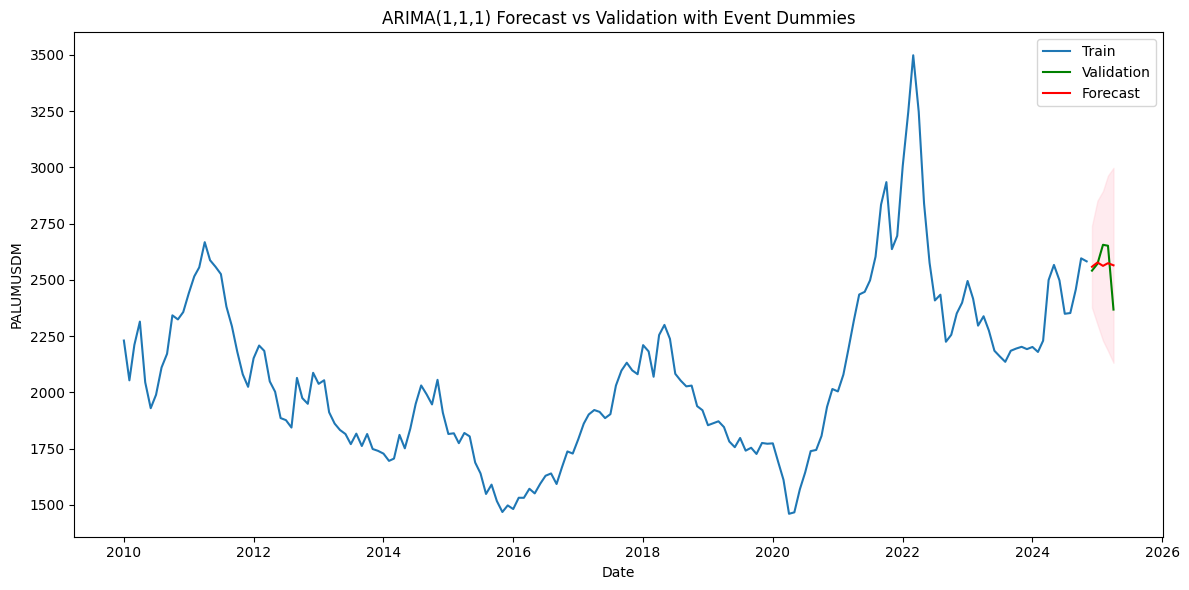

In [29]:
future_dates = pd.date_range(start=train.index[-1] + pd.offsets.MonthBegin(1), periods=5, freq='MS')
future_exog = pd.DataFrame({
    'dummy_ukraine_war': [0]*5
}, index=future_dates)

forecast = result_with_dummy.get_forecast(steps=5, exog=future_exog)
forecast_df = forecast.summary_frame()

plt.figure(figsize=(12, 6))
plt.plot(train['PALUMUSDM'], label='Train')
plt.plot(val['PALUMUSDM'], label='Validation', color='green')
plt.plot(forecast_df['mean'], label='Forecast', color='red')
plt.fill_between(forecast_df.index,
                 forecast_df['mean_ci_lower'],
                 forecast_df['mean_ci_upper'],
                 color='pink', alpha=0.3)

plt.title('ARIMA(1,1,1) Forecast vs Validation with Event Dummies')
plt.xlabel('Date')
plt.ylabel('PALUMUSDM')
plt.legend()
plt.tight_layout()
plt.show()

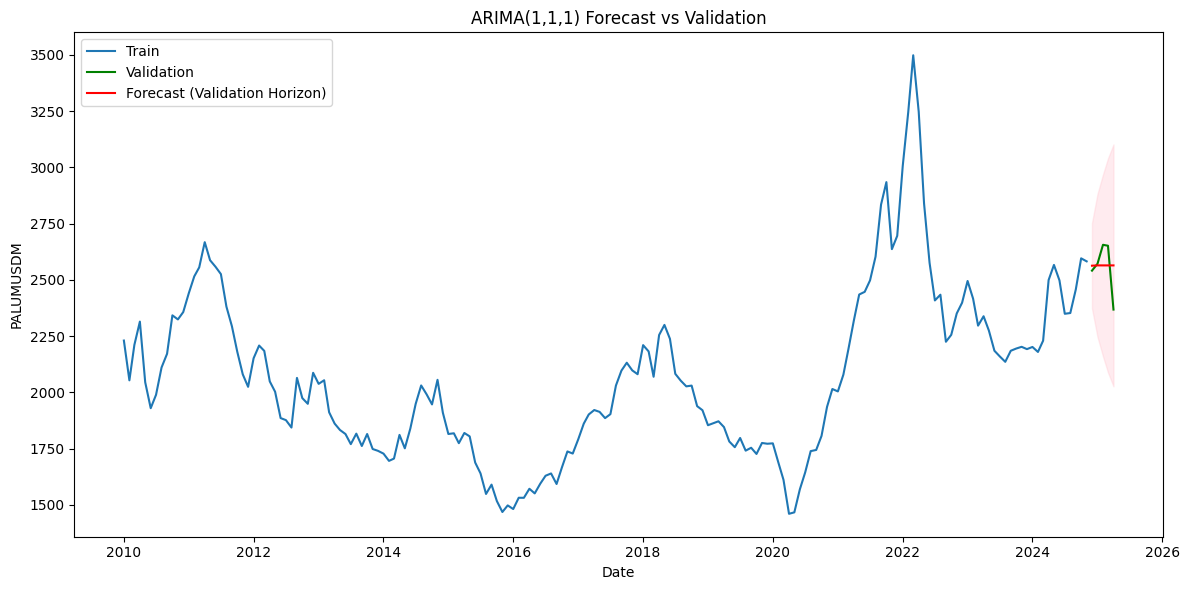

In [30]:
forecast = result_without_dummy.get_forecast(steps=5)
forecast_df = forecast.summary_frame()

plt.figure(figsize=(12, 6))
plt.plot(train['PALUMUSDM'], label='Train')
plt.plot(val['PALUMUSDM'], label='Validation', color='green')
plt.plot(forecast_df['mean'], label='Forecast (Validation Horizon)', color='red')
plt.fill_between(forecast_df.index,
                 forecast_df['mean_ci_lower'],
                 forecast_df['mean_ci_upper'],
                 color='pink', alpha=0.3)

plt.legend()
plt.title('ARIMA(1,1,1) Forecast vs Validation')
plt.xlabel('Date')
plt.ylabel('PALUMUSDM')
plt.tight_layout()
plt.show()

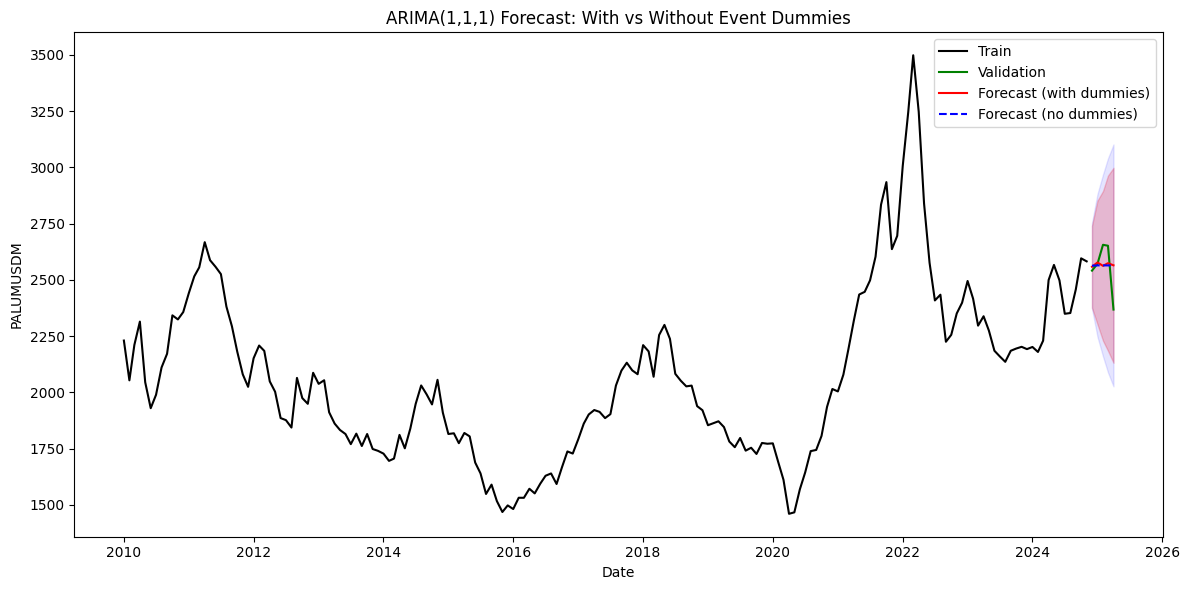

In [31]:
y = train['PALUMUSDM'].dropna()
exog = train[['dummy_covid_dip', 'dummy_covid_surge', 'dummy_ukraine_war']].loc[y.index]

future_dates = pd.date_range(start=train.index[-1] + pd.offsets.MonthBegin(1), periods=5, freq='MS')
future_exog = pd.DataFrame({
    'dummy_ukraine_war': [0]*5
}, index=future_dates)

forecast_with = result_with_dummy.get_forecast(steps=5, exog=future_exog)
forecast_with_df = forecast_with.summary_frame()

forecast_without = result_without_dummy.get_forecast(steps=5)
forecast_without_df = forecast_without.summary_frame()

plt.figure(figsize=(12, 6))
plt.plot(train['PALUMUSDM'], label='Train', color='black')
plt.plot(val['PALUMUSDM'], label='Validation', color='green')

plt.plot(forecast_with_df['mean'], label='Forecast (with dummies)', color='red', linestyle='-')
plt.plot(forecast_without_df['mean'], label='Forecast (no dummies)', color='blue', linestyle='--')

plt.fill_between(forecast_with_df.index,
                 forecast_with_df['mean_ci_lower'],
                 forecast_with_df['mean_ci_upper'],
                 color='red', alpha=0.2)

plt.fill_between(forecast_without_df.index,
                 forecast_without_df['mean_ci_lower'],
                 forecast_without_df['mean_ci_upper'],
                 color='blue', alpha=0.1)

plt.title('ARIMA(1,1,1) Forecast: With vs Without Event Dummies')
plt.xlabel('Date')
plt.ylabel('PALUMUSDM')
plt.legend()
plt.tight_layout()
plt.show()

In [32]:
val

,PALUMUSDM,dummy_covid_dip,dummy_covid_surge,dummy_ukraine_war
observation_date,,,,
2024-12-01,2540.882273,0,0,0
2025-01-01,2571.370435,0,0,0
2025-02-01,2655.772500,0,0,0
2025-03-01,2651.598571,0,0,0
2025-04-01,2367.800455,0,0,0


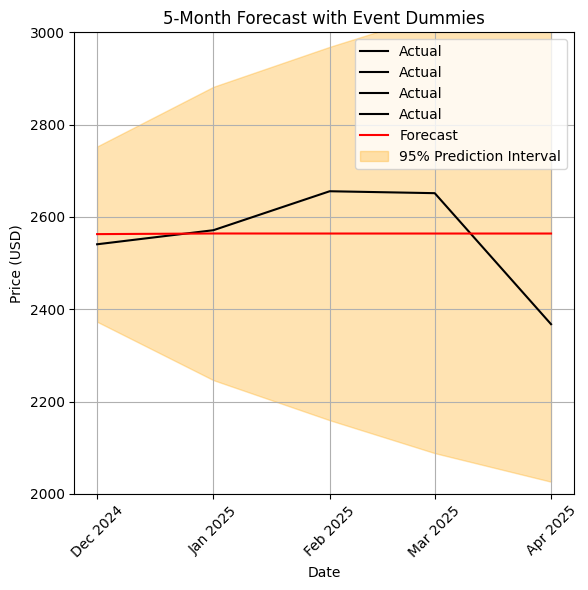

In [33]:
plt.figure(figsize=(6, 6))

plt.plot(val.index, val, label='Actual', color='black')

plt.plot(forecast_df.index, forecast_df['mean'], label='Forecast', color='red')

plt.fill_between(forecast_df.index,
                 forecast_df['mean_ci_lower'],
                 forecast_df['mean_ci_upper'],
                 color='orange', alpha=0.3, label='95% Prediction Interval')

plt.ylim(2000, 3000)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)

plt.title('5-Month Forecast with Event Dummies')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
y_true = val.squeeze() 

y_pred_with = forecast_with_df['mean']
y_true_with = y_true.loc[y_pred_with.index]
y_true_with = y_true_with['PALUMUSDM'].dropna()

mae_with = mean_absolute_error(y_true_with, y_pred_with)
rmse_with = np.sqrt(mean_squared_error(y_true_with, y_pred_with))
mask_with = y_true_with != 0
mape_with = np.mean(np.abs((y_true_with[mask_with] - y_pred_with[mask_with]) / y_true_with[mask_with])) * 100

y_pred_without = forecast_without_df['mean']
y_true_without = y_true.loc[y_pred_without.index]
y_true_without = y_true_without['PALUMUSDM'].dropna()

mae_without = mean_absolute_error(y_true_without, y_pred_without)
rmse_without = np.sqrt(mean_squared_error(y_true_without, y_pred_without))
mask_without = y_true_without != 0
mape_without = np.mean(np.abs((y_true_without[mask_without] - y_pred_without[mask_without]) / y_true_without[mask_without])) * 100

print("Forecast Evaluation on Validation Set:")
print("Metric           | With Dummies   | Without Dummies")
print("---------------------------------------------------")
print(f"MAE              | {mae_with:.2f}           | {mae_without:.2f}")
print(f"RMSE             | {rmse_with:.2f}           | {rmse_without:.2f}")
print(f"MAPE (%)         | {mape_with:.2f}%          | {mape_without:.2f}%")

Forecast Evaluation on Validation Set:
Metric           | With Dummies   | Without Dummies
---------------------------------------------------
MAE              | 78.22           | 80.91
RMSE             | 103.78           | 105.01
MAPE (%)         | 3.13%          | 3.24%



Forecast for Next 5 Months with Russia-Ukraine Dummy:
            Forecast  Lower CI  Upper CI
2025-05-01   2689.33   2505.23   2873.43
2025-06-01   2704.15   2425.09   2983.21
2025-07-01   2692.46   2355.13   3029.79
2025-08-01   2701.68   2306.71   3096.65
2025-09-01   2694.41   2254.86   3133.96


/Users/moneesh/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/moneesh/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/moneesh/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


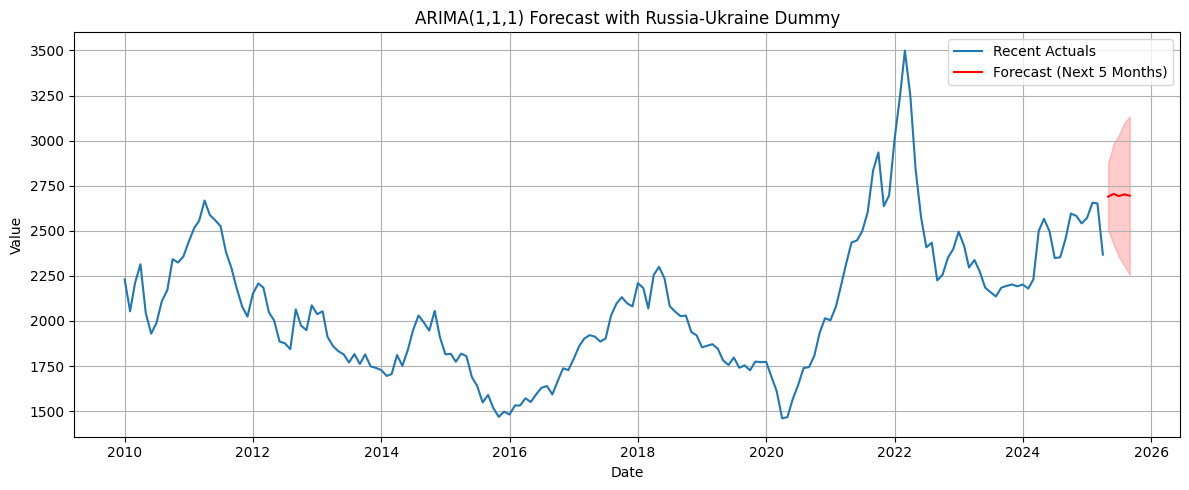

In [35]:
full_y = pd.concat([train['PALUMUSDM'], val['PALUMUSDM']])
full_exog = pd.concat([train[['dummy_ukraine_war']], val[['dummy_ukraine_war']]])

future_index = pd.date_range(start=val.index[-1] + pd.offsets.MonthBegin(1), periods=5, freq='MS')
future_exog = pd.DataFrame({'dummy_ukraine_war': [1]*5}, index=future_index)  

model = ARIMA(full_y, exog=full_exog, order=(1, 1, 1))
results = model.fit()

forecast_result = results.get_forecast(steps=5, exog=future_exog)
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

forecast_df = pd.DataFrame({
    'Forecast': forecast_mean,
    'Lower CI': conf_int.iloc[:, 0],
    'Upper CI': conf_int.iloc[:, 1]
})
print("\nForecast for Next 5 Months with Russia-Ukraine Dummy:")
print(forecast_df.round(2))

plt.figure(figsize=(12, 5))
plt.plot(full_y[:], label='Recent Actuals')
plt.plot(forecast_df['Forecast'], label='Forecast (Next 5 Months)', color='red')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], color='red', alpha=0.2)
plt.title("ARIMA(1,1,1) Forecast with Russia-Ukraine Dummy")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

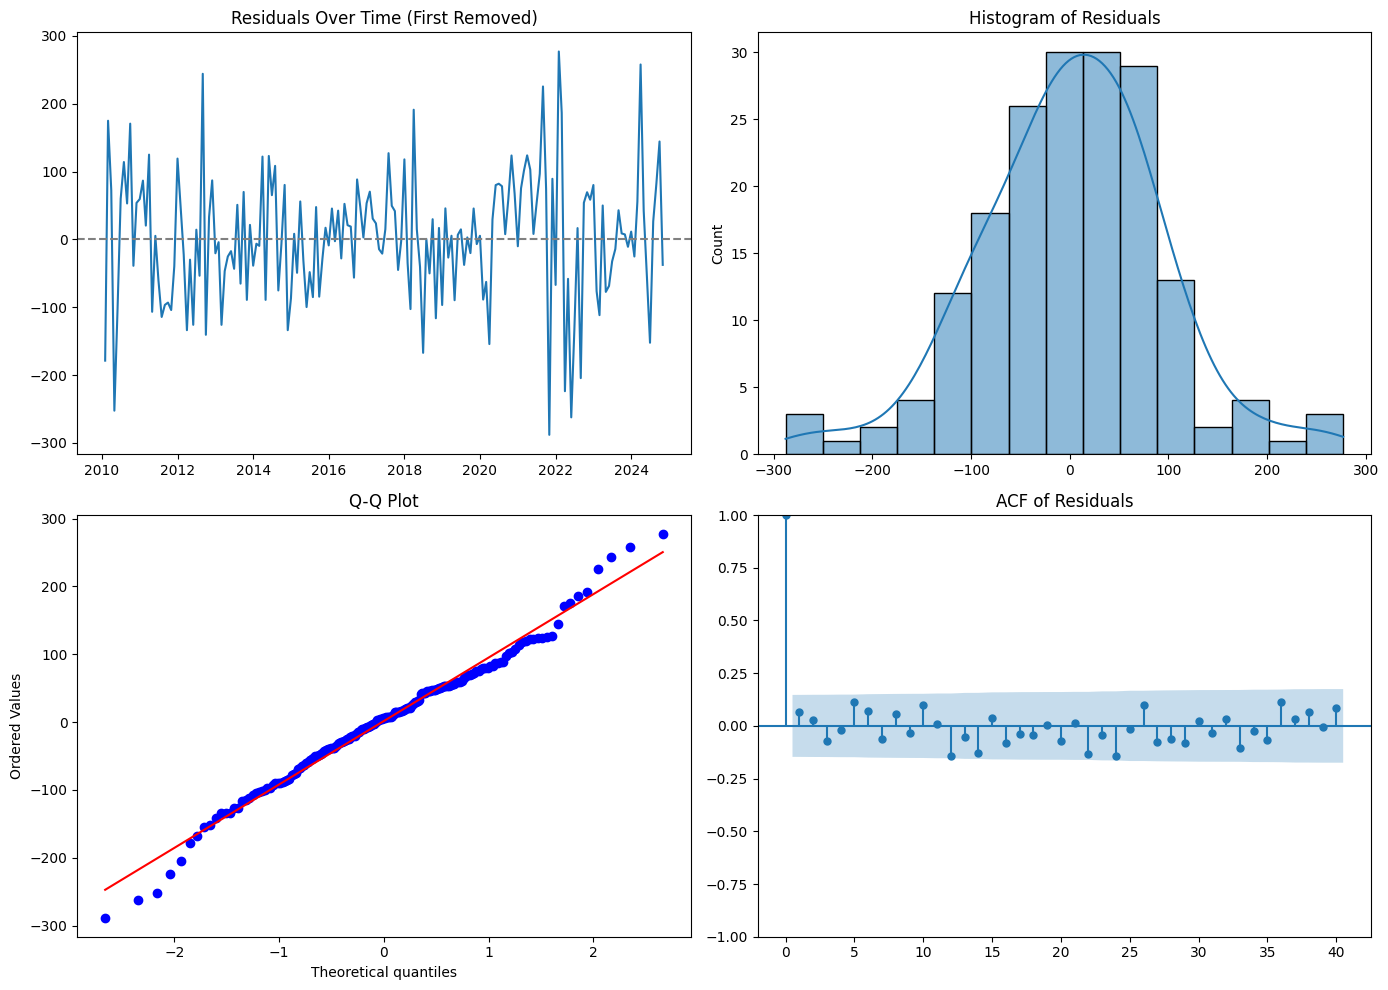

In [36]:
residuals = result_with_dummy.resid[1:]

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='gray')
plt.title("Residuals Over Time (First Removed)")

plt.subplot(2, 2, 2)
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")

plt.subplot(2, 2, 3)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")

plt.subplot(2, 2, 4)
plot_acf(residuals, ax=plt.gca(), lags=40)
plt.title("ACF of Residuals")

plt.tight_layout()
plt.show()

In [37]:
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)

statistic = lb_test['lb_stat'].values[0]
p_value = lb_test['lb_pvalue'].values[0]

print("Ljung-Box Test (lag=10):")
print(f"Test Statistic: {statistic:.4f}")
print(f"P-value: {p_value:.4f}")

alpha = 0.05
if p_value > alpha:
    print("\n Fail to reject the null hypothesis:")
    print("Residuals are independently distributed (i.e., no significant autocorrelation remains).")
else:
    print("\n Reject the null hypothesis:")
    print("Residuals are autocorrelated — model may be mis-specified.")

Ljung-Box Test (lag=10):
Test Statistic: 8.6701
P-value: 0.5637

 Fail to reject the null hypothesis:
Residuals are independently distributed (i.e., no significant autocorrelation remains).


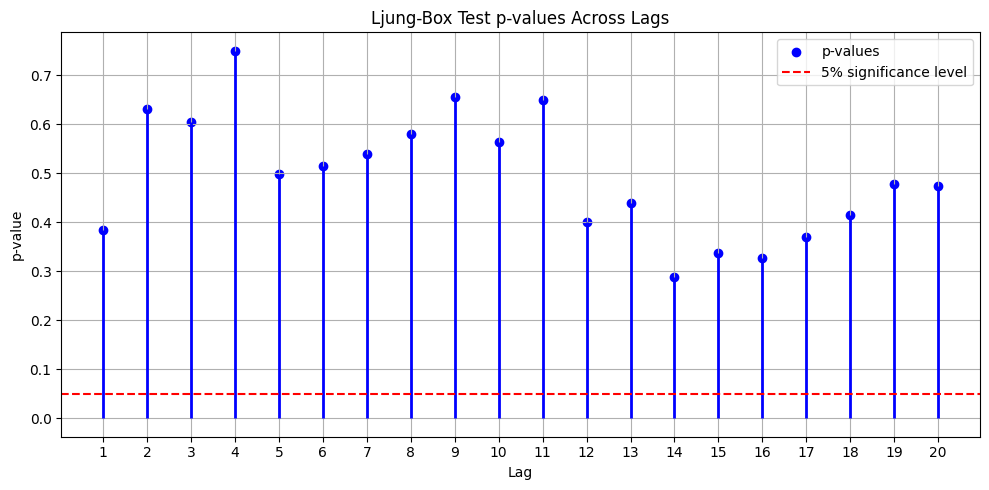

In [38]:
ljung_results = acorr_ljungbox(residuals, lags=20, return_df=True)

plt.figure(figsize=(10, 5))
plt.vlines(ljung_results.index, ymin=0, ymax=ljung_results['lb_pvalue'], color='blue', linewidth=2)
plt.scatter(ljung_results.index, ljung_results['lb_pvalue'], color='blue', label='p-values')

plt.axhline(y=0.05, color='red', linestyle='--', label='5% significance level')

plt.title('Ljung-Box Test p-values Across Lags')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.xticks(ljung_results.index)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [39]:
import warnings, numpy as np, pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings("ignore")

def metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)   
    rmse = mse ** 0.5
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE_%": mape}

def arima_one_step(train_y, train_ex, next_ex, order):
    """Fit once on train_y/ train_ex then one-step forecast using next_ex."""
    res = ARIMA(train_y, order=order, exog=train_ex).fit()
    return float(res.forecast(steps=1, exog=next_ex)[0])

def fixed_forecast(series, exog, test_len, order):
    train_y, test_y = series[:-test_len], series[-test_len:]
    train_ex, test_ex = exog.loc[train_y.index], exog.loc[test_y.index]

    preds = (ARIMA(train_y, order=order, exog=train_ex)
             .fit()
             .forecast(steps=test_len, exog=test_ex)
             .values)
    return preds, metrics(test_y.values, preds)

def recursive_forecast(series, exog, test_len, order):
    train_y  = series[:-test_len].copy()
    train_ex = exog.loc[train_y.index].copy()
    test_y   = series[-test_len:]
    preds = []

    for idx in test_y.index:
        next_ex = exog.loc[[idx]]         
        y_hat   = arima_one_step(train_y, train_ex, next_ex, order)
        preds.append(y_hat)

        train_y  = pd.concat([train_y, pd.Series([y_hat], index=[idx])])
        train_ex = pd.concat([train_ex, next_ex])

    return np.array(preds), metrics(test_y.values, preds)

def rolling_forecast(series, exog, *, test_len, order):
    """
    Rolling-window ARIMAX where the initial window is the **full** training set.
    After each 1-step forecast we drop the oldest observation and
    append the actual value that just became available.
    """
    train_y_full  = series[:-test_len]          
    train_ex_full = exog.loc[train_y_full.index]

    test_y        = series[-test_len:]
    test_ex       = exog.loc[test_y.index]

    roll_y, roll_ex = train_y_full.copy(), train_ex_full.copy()

    preds = []

    for idx in test_y.index:
        next_ex = test_ex.loc[[idx]]          
        y_hat   = arima_one_step(roll_y, roll_ex, next_ex, order)
        preds.append(y_hat)

        roll_y  = pd.concat([roll_y.iloc[1:], pd.Series([test_y[idx]], index=[idx])])
        roll_ex = pd.concat([roll_ex.iloc[1:], next_ex])

    preds = np.asarray(preds, dtype=float)
    return preds, metrics(test_y.values, preds)

if __name__ == "__main__":
    date_col  = "observation_date"
    value_col = "PALUMUSDM"

    df = pd.read_csv("PALUMUSDM.csv", parse_dates=[date_col])
    df = df[df[date_col] >= "2010-01-01"]              

    series = df.set_index(date_col)[value_col].dropna().astype(float)

    df["dummy_ukraine_war"] = ((df[date_col] >= "2022-01-01") &
                               (df[date_col] <= "2022-04-01")).astype(int)
    exog = (df.set_index(date_col)["dummy_ukraine_war"]
              .astype(int)
              .to_frame())                         

    exog = exog.loc[series.index]

    TEST_LEN = 5
    ORDER    = (1, 1, 1)

    results, forecast_lines = {}, {}
    test_idx = series.index[-TEST_LEN:]

    preds, res = fixed_forecast(series, exog, TEST_LEN, ORDER)
    results["Fixed"] = res
    fixed_line = pd.Series(np.nan, index=series.index)
    fixed_line.loc[test_idx] = preds
    forecast_lines["Fixed"] = fixed_line

    preds, res = recursive_forecast(series, exog, TEST_LEN, ORDER)
    results["Recursive"] = res
    rec_line = pd.Series(np.nan, index=series.index)
    rec_line.loc[test_idx] = preds
    forecast_lines["Recursive"] = rec_line

    preds, res = rolling_forecast(series, exog,
                              test_len=TEST_LEN, order=ORDER)
    results["Rolling"] = res
    roll_line = pd.Series(np.nan, index=series.index)
    roll_line.loc[test_idx] = preds
    forecast_lines["Rolling"] = roll_line

    # show metrics
    print("\nError metrics on the last 5 observations\n")
    print(pd.DataFrame(results).T.round(4))


Error metrics on the last 5 observations

               MAE      RMSE  MAPE_%
Fixed      78.2203  103.7801  3.1338
Recursive  78.2205  103.7842  3.1338
Rolling    85.0650  131.6347  3.4738


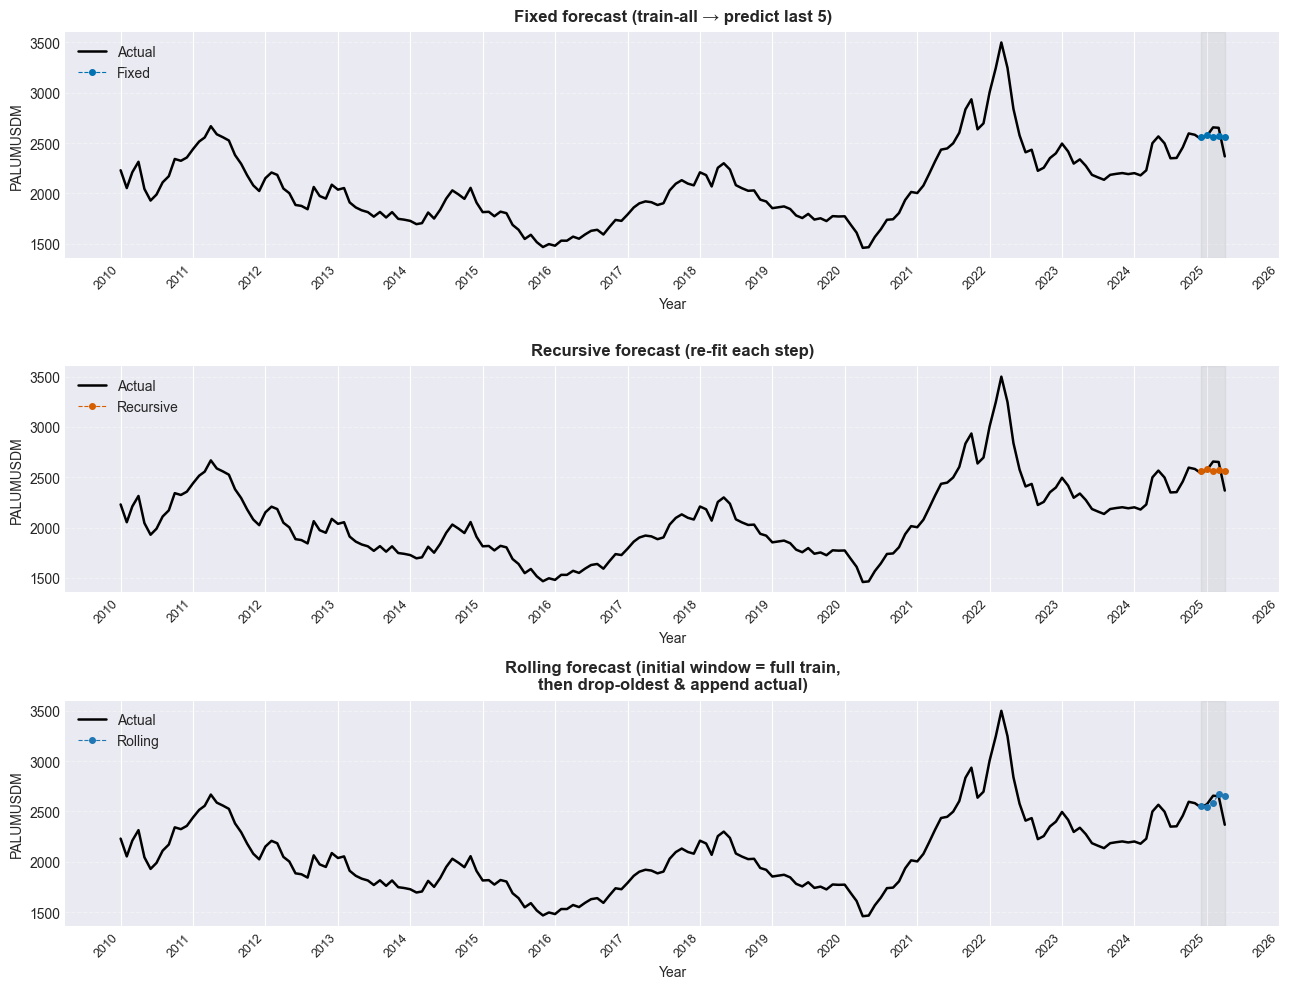

In [40]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np, pandas as pd

def _to_dt(idx):
    return idx if np.issubdtype(idx.dtype, np.datetime64) else pd.to_datetime(idx)

series.index = _to_dt(series.index)
for k in forecast_lines:
    forecast_lines[k].index = _to_dt(forecast_lines[k].index)
test_idx = series.index[-TEST_LEN:]        

plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams.update({
    "axes.spines.top": False, "axes.spines.right": False,
    "axes.titleweight": "bold", "legend.frameon": False})

def style(ax, title):
    ax.axvspan(test_idx[0], test_idx[-1], color="grey", alpha=0.10)
    ax.set_title(title, pad=8)
    ax.set_xlabel("Year")
    ax.set_ylabel(value_col)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    plt.setp(ax.get_xticklabels(),
             rotation=45, ha="right", fontsize=9)
    ax.grid(axis="y", linestyle="--", alpha=0.35)

fig, axes = plt.subplots(3, 1, figsize=(13, 10))

axes[0].plot(series, color="black", lw=1.8, label="Actual")
axes[0].plot(forecast_lines["Fixed"],
             marker="o", ms=4,
             ls="--", lw=0.8, color="#0072B2", label="Fixed")
style(axes[0], "Fixed forecast (train-all → predict last 5)")
axes[0].legend()

axes[1].plot(series, color="black", lw=1.8, label="Actual")
axes[1].plot(forecast_lines["Recursive"],
             marker="o", ms=4,
             ls="--", lw=0.8, color="#D55E00", label="Recursive")
style(axes[1], "Recursive forecast (re-fit each step)")
axes[1].legend()

axes[2].plot(series, color="black", lw=1.8, label="Actual")
axes[2].plot(forecast_lines["Rolling"],
             marker="o", ms=4,
             ls="--", lw=0.8, color="#1f77b4", label="Rolling")
style(axes[2], "Rolling forecast (initial window = full train,\n"
               "then drop-oldest & append actual)")
axes[2].legend()

fig.tight_layout()
plt.show()